In [1]:
import pymc3 as pm

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import scipy.stats as scistats
from scipy.special import binom

In [4]:
from collections import defaultdict

In [5]:
from functools import reduce

In [6]:
import seaborn as sb

In [7]:
# -*- coding: utf-8 -*-

import codecs

def get_basic_phoneme(phoneme):
	if phoneme[-1].isdigit():
		return phoneme[:-1]
	return phoneme

def get_phonemes(phonemes_code):
	return tuple([get_basic_phoneme(phoneme_code) for phoneme_code in phonemes_code.split(';')])

def get_pg_pair(pg_pair_code):
	phonemes_code, grapheme = pg_pair_code.split('>')
	return (get_phonemes(phonemes_code), grapheme)

def get_mapping(mapping_code):
	return tuple([get_pg_pair(pg_pair_code) for pg_pair_code in mapping_code.split('|')])

def read_phonix(input_file_name):
	phonix = []
	with codecs.open(input_file_name, encoding = 'utf-8') as input_file:
		for line in input_file:
			line = line.strip()
			if not line: continue
			word, mapping_code = line.split(' ')
			phonix.append((word, get_mapping(mapping_code)))
	return phonix

def pg_pair_to_str(pg_pair):
	phonemes, grapheme = pg_pair
	return '%s>%s' % (';'.join(phonemes), grapheme)

def mapping_to_str(mapping):
	return '|'.join(pg_pair_to_str(pg_pair) for pg_pair in mapping)

In [8]:
def read_freq_list(freq_file_name):
    wordfreqs = {}
    with open(freq_file_name) as input_file:
        for line in input_file:
            line = line.strip()
            word, freq = line.split(' ')
            freq = float(freq)
            wordfreqs[word] = freq
    return wordfreqs

In [9]:
def normalize(distr):
    denominator = sum(distr.values())
    return {key: float(value) / denominator for key, value in distr.items()}

In [10]:
def get_pg_freqs(wordfreqs, phonix):
    aggregator = defaultdict(float)
    for word, mapping in phonix:
        if word not in wordfreqs: continue
        wordfreq = wordfreqs[word]
        for pg in mapping:
            aggregator[pg_pair_to_str(pg)] += wordfreq
    return normalize(aggregator)

In [11]:
def load_pg_stat():
    phonix = read_phonix('../data/phonix.txt')
    wordfreqs = read_freq_list('../data/word-freqs.txt')
    pg_freqs = get_pg_freqs(wordfreqs, phonix)
    pgs = sorted(pg_freqs.keys(), key = lambda pg: pg_freqs[pg], reverse=True) # just wanted to sort it to have an intuitive ordering of pg-pairs
    pg_probs = np.array([pg_freqs[pg] for pg in pgs])
    pg_idx = {pg : i for i, pg in enumerate(pgs)}
    return {'idx' : pg_idx, 'p' : pg_probs}

In [12]:
pg_stat = load_pg_stat()

In [13]:
hyperparams = {'mu' : np.log(500), 'sigma' : 3}

In [16]:
def run_inference(hyperparams, pg_stat, target_pgs, observations):
    prior_mu = hyperparams['mu']
    prior_sigma = hyperparams['sigma']
    with pm.Model() as model:
        log_n = pm.Normal("log_n_pg_exposed", mu = prior_mu, sigma = prior_sigma)
        n = np.exp(log_n)
        probs_miss = dict()
        ps = pg_stat["p"]
        pg_idx = pg_stat["idx"]
        for pg in target_pgs:
            p = ps[pg_idx[pg]]
            varname = "p_miss_" + pg
            probs_miss[pg] = pm.Bound(pm.Lognormal, lower = 0, upper = 1)(varname, mu = -0.3 * n * p, sigma = 0.3 * np.sqrt(n * p * (1 - p)))
        for i, (pg, recall) in enumerate(observations):
            varname = "obs_%d" % i
            pm.Bernoulli(varname, p = probs_miss[pg], observed = not recall)
    with model:
        trace = pm.sample(tune = 1000, draws = 1000, return_inferencedata=False, target_accept = 0.95)
    pm.traceplot(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_miss_ʃ>ti, p_miss_θ>th, p_miss_p>p, p_miss_k>c, log_n_pg_exposed]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/usr/local/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


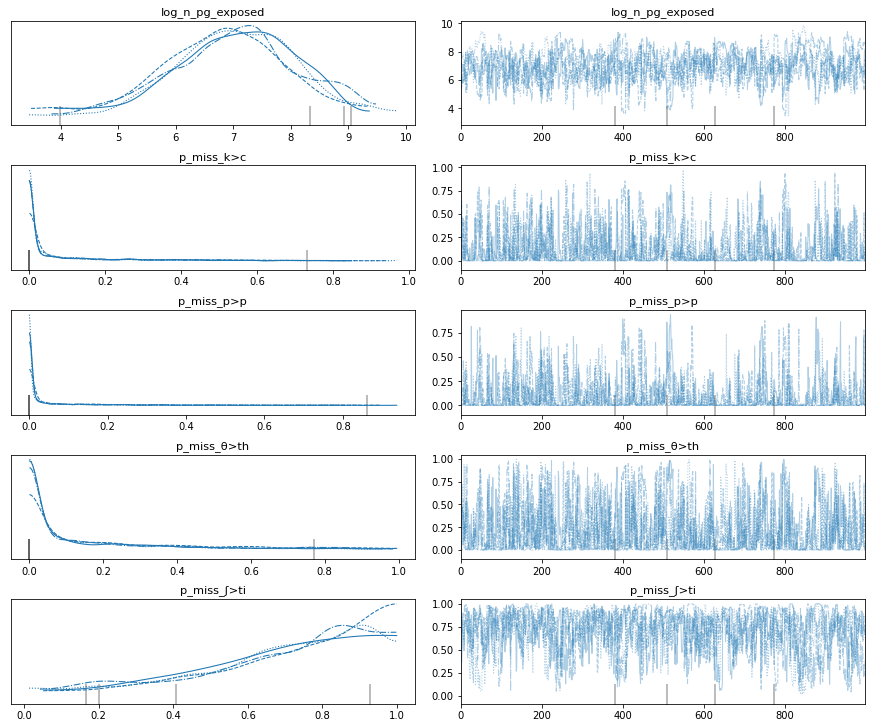

In [17]:
run_inference(hyperparams, pg_stat, ["k>c", "p>p", "θ>th", "ʃ>ti"], [("k>c", True), ("p>p", True), ("ʃ>ti", False)])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_miss_ʃ>ti, p_miss_θ>th, p_miss_p>p, p_miss_k>c, log_n_pg_exposed]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
The number of effective samples is smaller than 10% for some parameters.
/usr/local/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


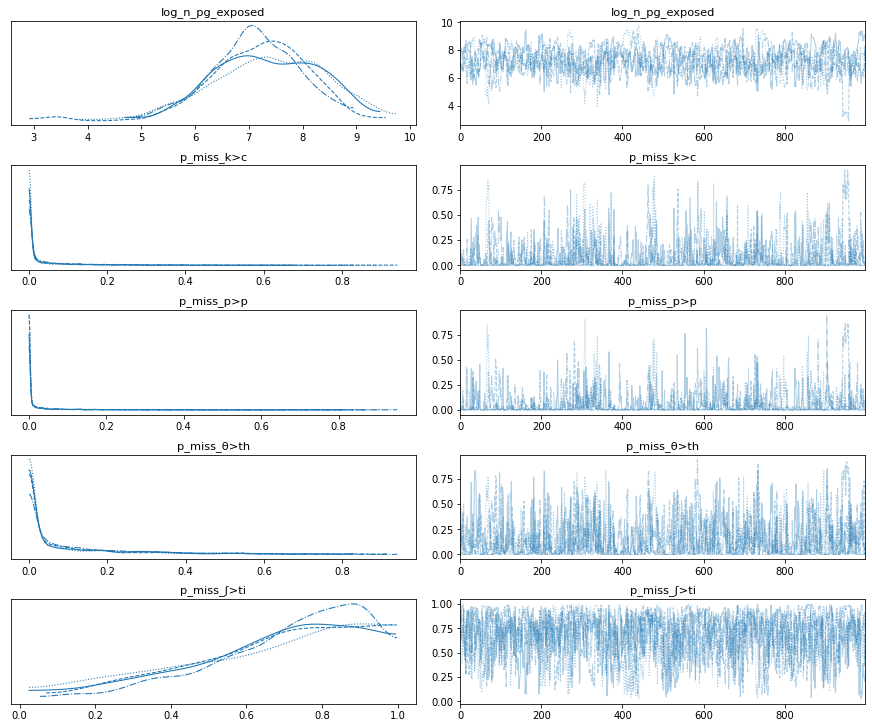

In [18]:
run_inference(hyperparams, pg_stat, ["k>c", "p>p", "θ>th", "ʃ>ti"], [("k>c", True), ("p>p", True), ("θ>th", True), ("ʃ>ti", False)])

In [ ]:
run_inference(hyperparams, pg_stat, ["k>c", "p>p", "θ>th", "ʃ>ti"], [("k>c", True), ("p>p", False)])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_miss_ʃ>ti, p_miss_θ>th, p_miss_p>p, p_miss_k>c, log_n_pg_exposed]


In [ ]:
run_inference(hyperparams, pg_stat, ["k>c", "p>p", "θ>th", "ʃ>ti"], [("k>c", True), ("k>c", True), ("k>c", True), ("p>p", False), ("p>p", False), ("p>p", False)])